In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=3, margin_length=0.1, p=2, min_split_sample=2):
        # Initialize hyperparameters
        self.max_depth = max_depth  # Maximum depth of the tree
        self.margin_length = margin_length  # Margin length for hinge error
        self.p = p  # Power for hinge error calculation
        self.min_split_sample = min_split_sample  # Minimum samples required to split a node
        self.tree = None  # Placeholder for the tree structure

    def relu(self, x):
        # ReLU function for hinge error calculation
        return np.maximum(0, x)

    def hinge_error(self, y_pred, y_low, y_up):
        # Calculate hinge error based on prediction and interval targets
        return (self.relu(y_low - y_pred + self.margin_length) ** self.p +
                self.relu(y_pred - y_up + self.margin_length) ** self.p)

    def best_split(self, X, y):
        # Determine the best feature and threshold for splitting the data
        n_samples, n_features = X.shape
        best_feature, best_threshold = None, None
        min_error = float('inf')

        for feature in range(n_features):
            # Iterate over all unique thresholds for the current feature
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = X[:, feature] > threshold

                # Ensure both splits are valid
                if np.sum(left_mask) >= self.min_split_sample and np.sum(right_mask) >= self.min_split_sample:
                    left_y = y[left_mask]
                    right_y = y[right_mask]

                    # Evaluate the split using hinge error
                    error = self.evaluate_split(left_y) + self.evaluate_split(right_y)

                    # Update the best split if current split has lower error
                    if error < min_error:
                        min_error = error
                        best_feature = feature
                        best_threshold = threshold

        return best_feature, best_threshold

    def evaluate_split(self, y):
        # Evaluate the hinge error for a split
        y_low = y[:, 0]
        y_up = y[:, 1]
        valid_values = np.concatenate([y_low[y_low != -np.inf], y_up[y_up != np.inf]])

        if len(valid_values) == 0:
            # No valid values, return zero error
            return 0

        # Compute hinge error for each potential prediction value
        errors = [np.sum(self.hinge_error(val, y_low, y_up)) for val in valid_values]
        return np.min(errors)

    def predict_leaf_value(self, y):
        # Predict the value at a leaf node
        y_low = y[:, 0]
        y_up = y[:, 1]
        valid_values = np.concatenate([y_low[y_low != -np.inf], y_up[y_up != np.inf]])

        if len(valid_values) == 0:
            # Default prediction if no valid values
            return 0

        # Find the prediction value that minimizes hinge error
        errors = [np.sum(self.hinge_error(val, y_low, y_up)) for val in valid_values]
        return valid_values[np.argmin(errors)]

    def build_tree(self, X, y, depth):
        # Recursively build the decision tree
        if depth == self.max_depth or len(X) < self.min_split_sample:
            # Stop splitting if max depth is reached or not enough samples
            return {
                'type': 'leaf',
                'value': self.predict_leaf_value(y)
            }

        # Find the best split for the current node
        feature, threshold = self.best_split(X, y)
        if feature is None:
            # If no valid split, create a leaf node
            return {
                'type': 'leaf',
                'value': self.predict_leaf_value(y)
            }

        # Split the data into left and right subsets
        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        # Recursively build left and right branches
        return {
            'type': 'node',
            'feature': feature,
            'threshold': threshold,
            'left': self.build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self.build_tree(X[right_mask], y[right_mask], depth + 1)
        }

    def fit(self, X, y):
        # Fit the decision tree to the data
        self.tree = self.build_tree(X, y, 0)

    def predict_one(self, x, node):
        # Predict the target for a single instance
        if node['type'] == 'leaf':
            return node['value']

        # Traverse the tree based on feature thresholds
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    def predict(self, X):
        # Predict the target for all instances in the dataset
        return np.array([self.predict_one(x, self.tree) for x in X])
    
    def plot_tree_predictions(self, feature_n, X, y):
        # Plot the specified feature against target intervals and draw tree predictions
        plt.figure(figsize=(6, 4))

        # Control labels
        is_y_low_label_drawn = False
        is_y_up_label_drawn = False

        # Plot target intervals
        for i in range(len(X)):
            x = X[i, feature_n - 1]  # Use the specified feature
            y_low, y_up = y[i]

            # Vertical line between y_low and y_up, even if y_low or y_up is inf
            if y_low == -np.inf:
                y_low = np.min(y[y[:, 0] > -np.inf, 0]) - 1  # Extend line below min finite y_low
            if y_up == np.inf:
                y_up = np.max(y[y[:, 1] < np.inf, 1]) + 1  # Extend line above max finite y_up

            plt.plot([x, x], [y_low, y_up], color='gray', linestyle='--')

            # Hollow point for y_low and solid point for y_up
            if y[i, 0] != -np.inf:
                if is_y_low_label_drawn == False:
                    plt.scatter(x, y[i, 0], color='white', edgecolors='black', label='y_low')
                plt.scatter(x, y[i, 0], color='white', edgecolors='black')
                is_y_low_label_drawn = True
            if y[i, 1] != np.inf:
                if is_y_up_label_drawn == False:
                    plt.scatter(x, y[i, 1], color='black', edgecolors='black', label='y_up')
                plt.scatter(x, y[i, 1], color='black', edgecolors='black')
                is_y_up_label_drawn = True

        # Draw predicted values for each node
        def draw_node_predictions(node, xmin, xmax):
            if node['type'] == 'leaf':
                # Draw a horizontal line for the leaf prediction
                plt.plot([xmin, xmax], [node['value'], node['value']], color='gray', linestyle='-')
            else:
                # Recurse for left and right child nodes
                threshold = node['threshold']
                draw_node_predictions(node['left'], xmin, threshold)
                draw_node_predictions(node['right'], threshold, xmax)

        draw_node_predictions(self.tree, np.min(X[:, feature_n - 1]), np.max(X[:, feature_n - 1]))

        plt.xlabel(f"Feature {feature_n}")
        plt.ylabel("Target Interval")
        plt.legend()
        plt.title(f"MMIT: max_depth = {self.max_depth} & min_split_sample = {self.min_split_sample}")
        plt.show()

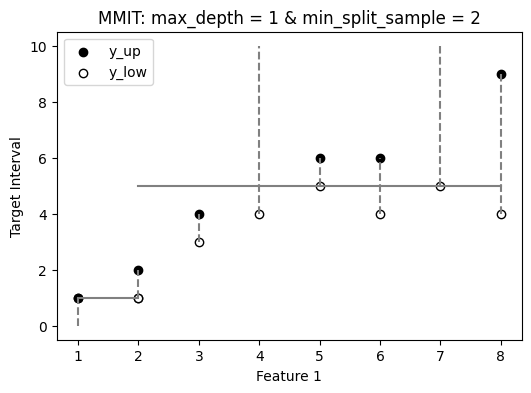

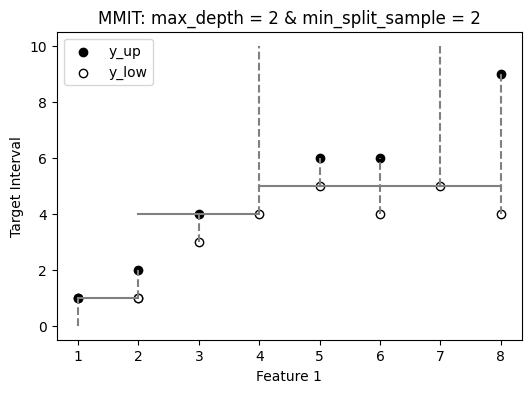

In [3]:
# Example Usage
X = np.array([[1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1]])
y = np.array([[-np.inf, 1], [1, 2], [3, 4], [4, np.inf], [5, 6], [4, 6], [5, np.inf], [4, 9]])

# Plot predictions
dtr = CustomDecisionTreeRegressor(max_depth=1, margin_length=0.1, p=2, min_split_sample=2)
dtr.fit(X, y)
dtr.plot_tree_predictions(1, X, y)

dtr = CustomDecisionTreeRegressor(max_depth=2, margin_length=0.1, p=2, min_split_sample=2)
dtr.fit(X, y)
dtr.plot_tree_predictions(1, X, y)

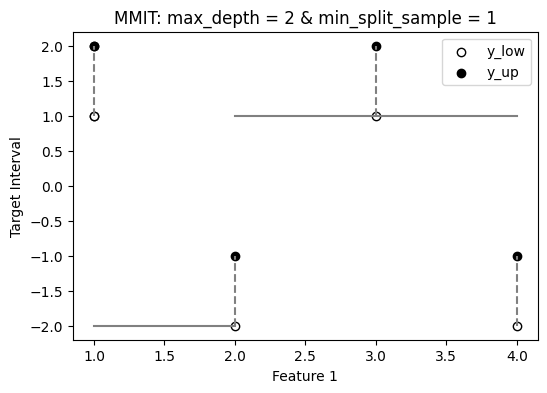

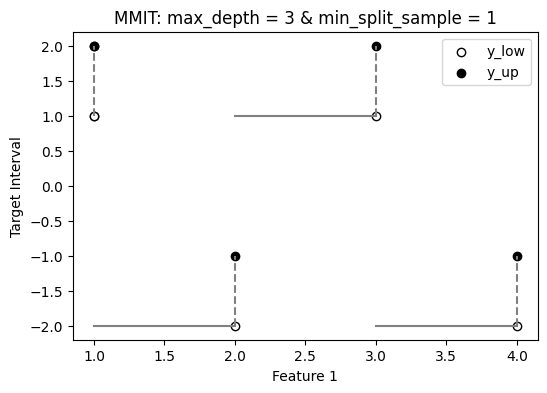

In [4]:
# Example Usage
X = np.array([[1, 1], [2, 1], [3, 1], [4, 1]])
y = np.array([[1, 2], [-2, -1], [1, 2], [-2, -1]])

# Plot predictions
dtr = CustomDecisionTreeRegressor(max_depth=2, margin_length=0.1, p=2, min_split_sample=1)
dtr.fit(X, y)
dtr.plot_tree_predictions(1, X, y)

dtr = CustomDecisionTreeRegressor(max_depth=3, margin_length=0.1, p=2, min_split_sample=1)
dtr.fit(X, y)
dtr.plot_tree_predictions(1, X, y)